In [1]:
import cv2
from PIL import Image
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import math

49 49 902 902
Side length (pixels): 37


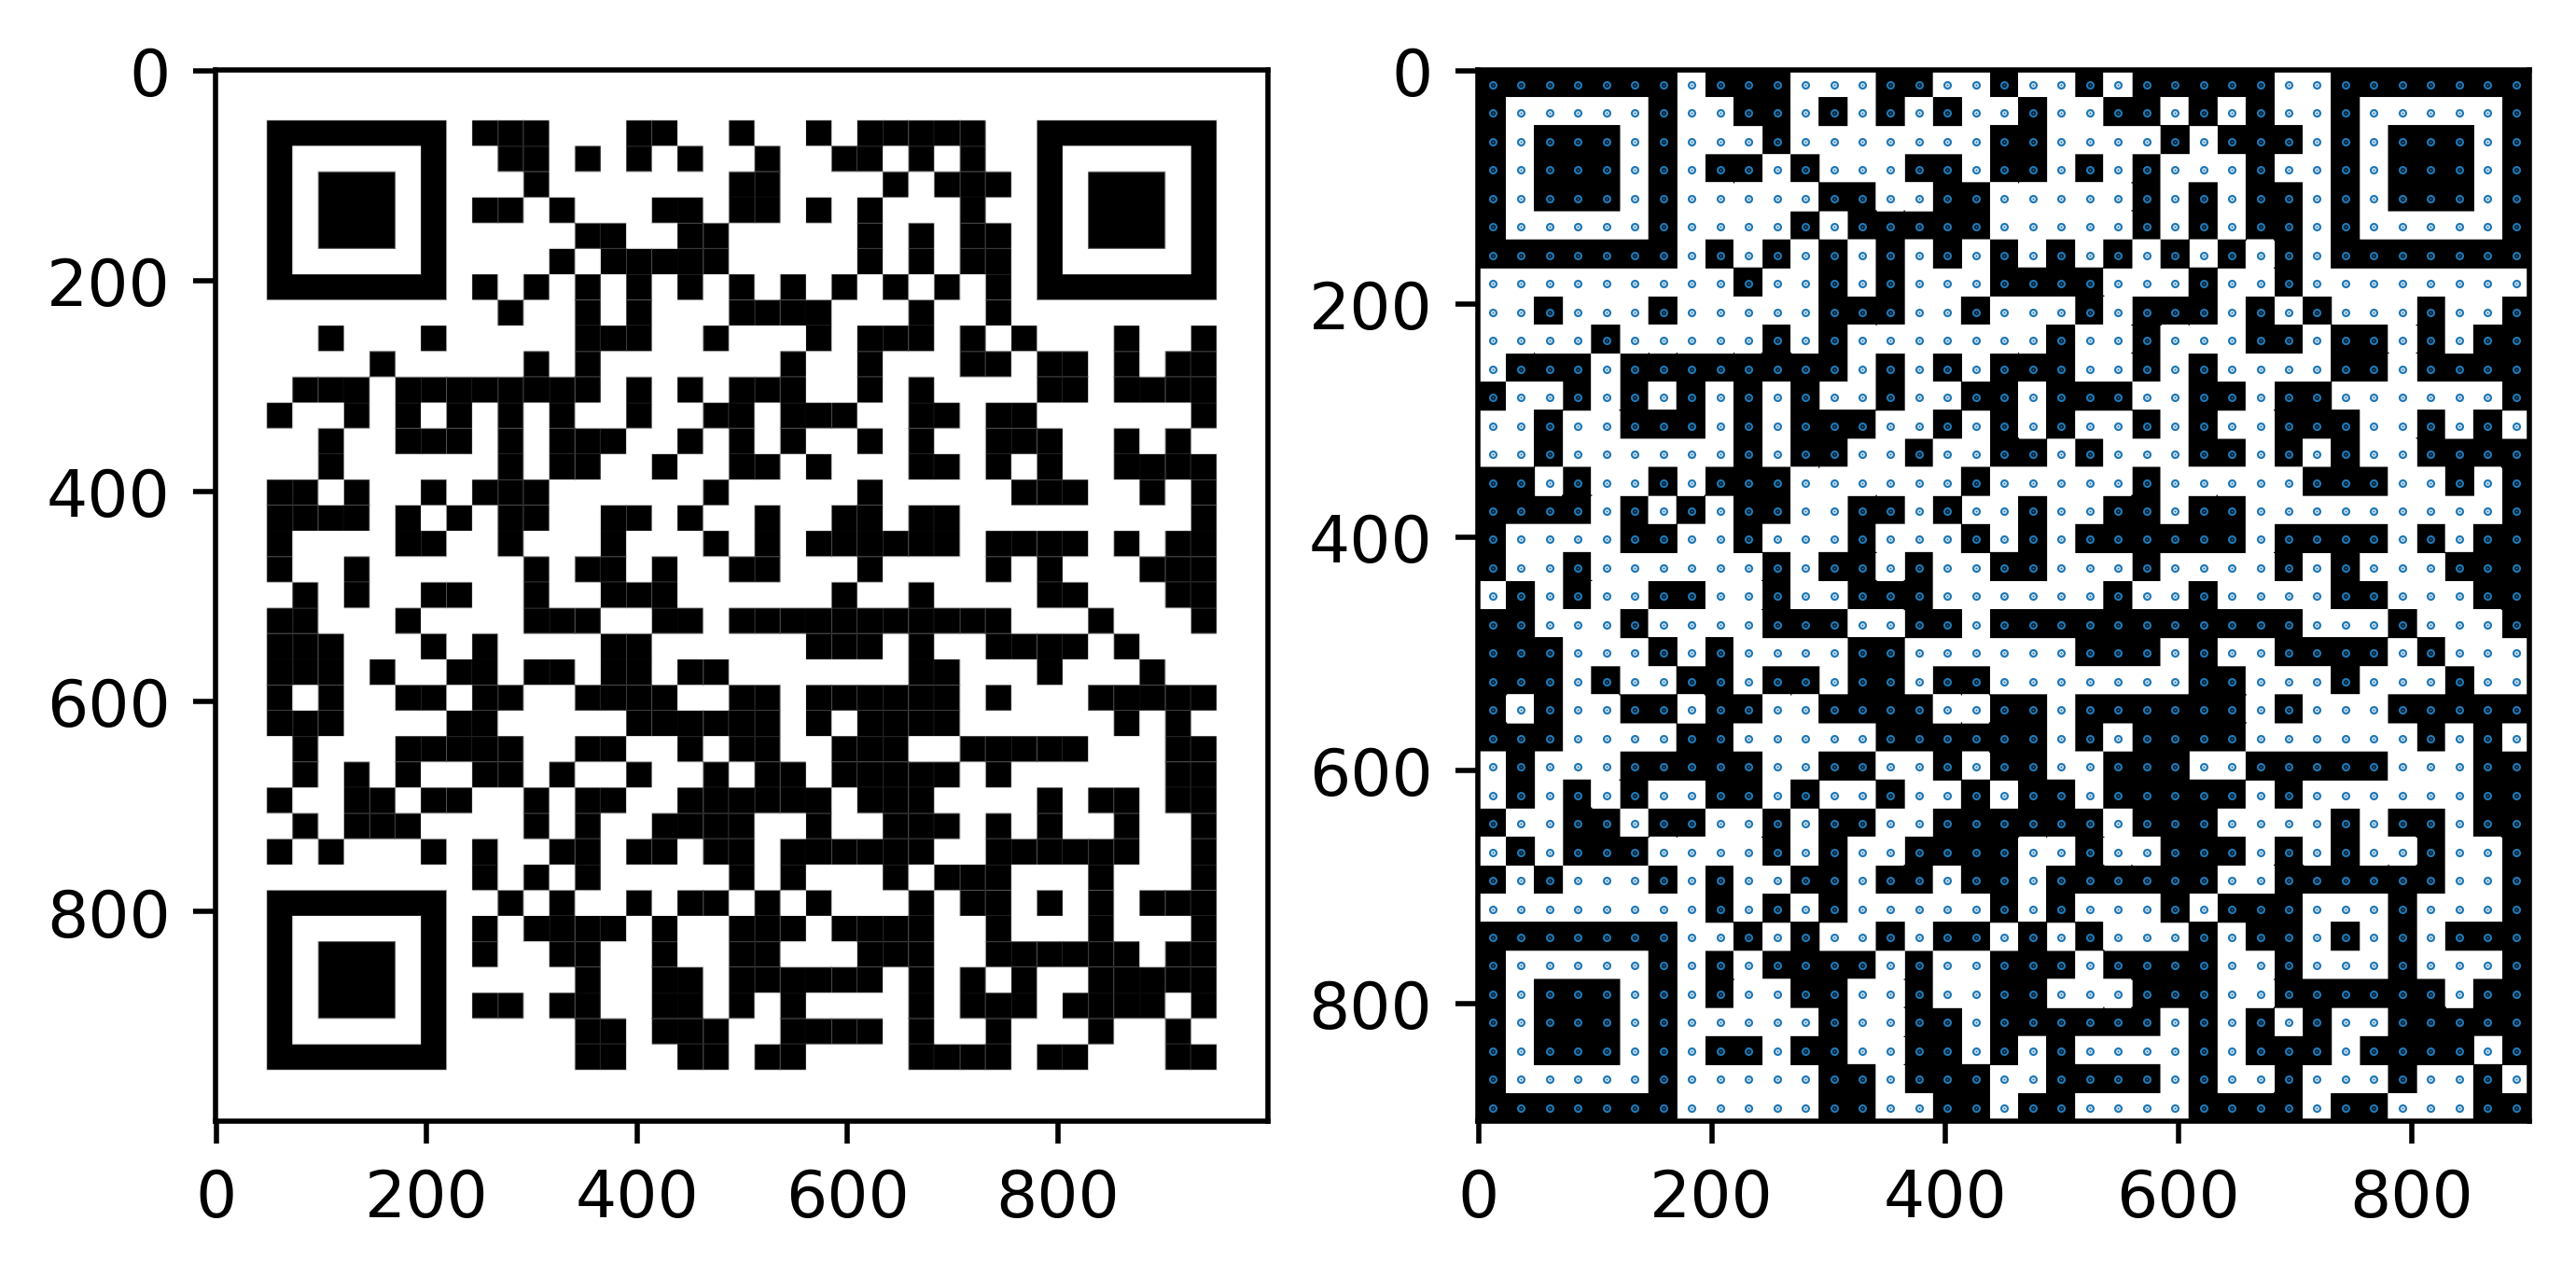

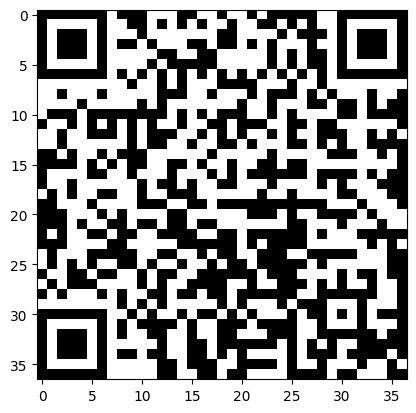

In [2]:
%matplotlib inline
VALID_DIMENSIONS = np.array([21+4*i for i in range(0,40)])

# read the QR Code image
original_img= cv2.imread("test_images/test_code_2.png",cv2.IMREAD_GRAYSCALE)
img = original_img.copy()

img = cv2.threshold(img,np.mean(img),255,cv2.THRESH_BINARY)[-1]
base_img_data = None
if int(sum(img.shape)/2) not in VALID_DIMENSIONS:
    coords = cv2.findNonZero((img < 1).astype(int)) # Find all non-zero points
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    print(x,y,w,h)

    img = img[y:y+h, x:x+w]

    def rle(inarray):
            """ run length encoding. Partial credit to R rle function. 
                Multi datatype arrays catered for including non Numpy
                returns: tuple (runlengths, startpositions, values) """
            ia = np.asarray(inarray)                # force numpy
            n = len(ia)
            if n == 0: 
                return (None, None, None)
            else:
                y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
                i = np.append(np.where(y), n - 1)   # must include last element posi
                z = np.diff(np.append(-1, i))       # run lengths
                p = np.cumsum(np.append(0, z))[:-1] # positions
                return (z, p, ia[i])

    run_lengths = []
    for i in range(img.shape[0]):
        row = img[i]==0
        row_run_lengths, start_positions, _ = rle(row)
        run_lengths += [row_run_lengths[j] for j, (rl,sp) in enumerate(zip(row_run_lengths, start_positions)) if row[sp] and rl > 1]
    rles = np.array(run_lengths).flatten()
    pixel_size_estimate = np.min(rles)

    side_length_pixels = (img.shape[0]+img.shape[1])/2 /pixel_size_estimate
    dimension_correction = np.abs(VALID_DIMENSIONS-side_length_pixels)
    side_length_pixels = VALID_DIMENSIONS[int(np.where(np.min(dimension_correction) == np.abs(VALID_DIMENSIONS-side_length_pixels))[0][0])]

    pixel_size_estimate_x = img.shape[1] / side_length_pixels
    pixel_size_estimate_y = img.shape[0] / side_length_pixels

    print(f'Side length (pixels): {side_length_pixels}')

    base_img_data = np.zeros((side_length_pixels,side_length_pixels))
    sample_points_x = np.array([[pixel_size_estimate_x/2+i*pixel_size_estimate_x for i in range(side_length_pixels)] for j in range(side_length_pixels)]).flatten()
    sample_points_y = np.array([[pixel_size_estimate_y/2+j*pixel_size_estimate_y for i in range(side_length_pixels)] for j in range(side_length_pixels)]).flatten()

    for px,py in zip(sample_points_x,sample_points_y):
        x = round((px-pixel_size_estimate_x/2)/pixel_size_estimate_x)
        y = round((py-pixel_size_estimate_y/2)/pixel_size_estimate_y)

        base_img_data[y,x] += img[round(py),round(px)]

    plt.rcParams['figure.dpi'] = 500
    fig,(ax1,ax2) = plt.subplots(1,2)

    ax1.imshow(original_img, cmap="Greys_r")

    ax2.imshow(img, cmap="Greys_r")
    ax2.scatter(sample_points_x,sample_points_y,s=0.1)

    plt.show()

else:
     base_img_data = img


plt.rcParams['figure.dpi'] = 100
fig,ax = plt.subplots(1,1)
ax.imshow(base_img_data, cmap="Greys_r")

plt.show()

#segments: 153
#segments (black): 105
#segments (white): 48
Border segment: 0


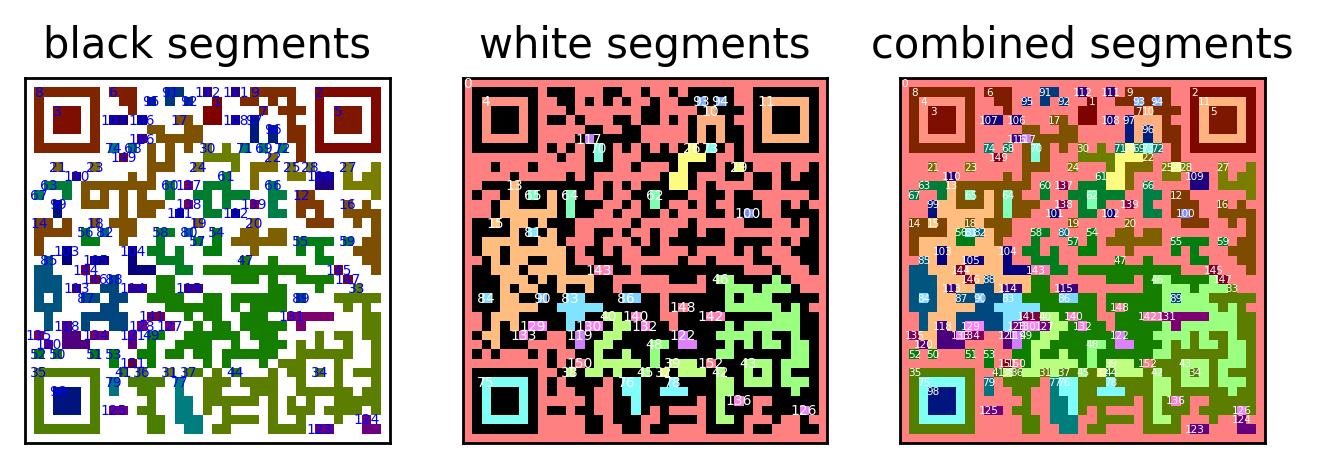

In [3]:
def compute_segments(img_data):
    segmented_image = img_data.copy().astype(int)
    W, H = segmented_image.shape

    x_indices = list(range(W))
    random.shuffle(x_indices)
    y_indices = list(range(H))
    random.shuffle(y_indices)

    last_pixel_count = W*H
    n_segments = 0
    n_segments_split = [0,0]
    segment_types = []
    segment_pixel_counts = []
    for i in x_indices:
        for j in y_indices:
            if segmented_image[i, j] == 0 or segmented_image[i, j] == 255:
                n_segments += 1
                n_segments_split[0 if segmented_image[i,j]==0 else 1] += 1
                segment_types.append(0 if segmented_image[i,j]==0 else 1)
                
                cv2.floodFill(segmented_image, None, (j, i), n_segments)

                new_pixel_count = np.sum(segmented_image == img_data)
                pixel_count_diff = last_pixel_count-new_pixel_count
                last_pixel_count = new_pixel_count

                segment_pixel_counts.append(pixel_count_diff)

    segmented_image -= 1
                
    return n_segments,n_segments_split,segment_types,segment_pixel_counts,segmented_image

img_data = np.pad(base_img_data, (1,1), 'constant',constant_values=255)
W, H = img_data.shape
n_segments, n_segments_split, segment_types, segment_pixel_counts, segmented_image = compute_segments(img_data)

border_segment = segmented_image[0,0]

print(f'#segments: {n_segments}')
print(f'#segments (black): {n_segments_split[0]}')
print(f'#segments (white): {n_segments_split[1]}')
print(f'Border segment: {border_segment}')

mask = cv2.threshold(img_data,250,1,cv2.THRESH_BINARY_INV)[1]

plt.rcParams['figure.dpi'] = 250
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

for ax in (ax1,ax2,ax3):
    ax.set_xticks([], [])
    ax.set_yticks([], [])

ax1.set_title("black segments")
ax1.imshow(img_data, cmap="Greys_r")
ax1.imshow(segmented_image*mask, alpha=mask*0.5, cmap="hsv")

ax2.set_title("white segments")
ax2.imshow(img_data, cmap="Greys_r")
ax2.imshow(segmented_image*(1-mask), alpha=(1-mask)*0.5, cmap="hsv")

ax3.set_title("combined segments")
ax3.imshow(img_data, cmap="Greys_r")
ax3.imshow(segmented_image, alpha=0.5, cmap="hsv")

for segment_id in range(n_segments):
    px = np.where(segmented_image == segment_id)[1]
    py = np.where(segmented_image == segment_id)[0]

    ax3.text(px[0], py[0], f'{segment_id}', va='center', ha='center',fontsize=3, color='white')
    match(segment_types[segment_id]):
        case 0:
            ax1.text(px[0], py[0], f'{segment_id}', va='center', ha='center',fontsize=4, color='blue')
        case 1:
            ax2.text(px[0], py[0], f'{segment_id}', va='center', ha='center',fontsize=4, color='white')



plt.show()

[[4], [4, 3], [13], [13, 103], [13, 113], [13, 56], [13, 56, 81], [13, 144], [13, 87], [13, 18], [13, 105], [13, 146], [13, 82], [13, 114], [15], [84], [75], [75, 98], [133], [65], [64], [117], [70], [129], [90], [83], [83, 128], [83, 141], [38], [119], [150], [40], [40, 127], [40, 37], [143], [130], [86], [140], [132], [48], [45], [39], [39, 44], [32], [148], [122], [142], [142, 131], [152], [46], [46, 89], [76], [62], [26], [26, 69], [78], [42], [136], [43], [43, 34], [126], [93], [94], [10], [10, 96], [29], [73], [100], [11], [11, 5]]
[0, 8, 4]
[0, 8, 4, 3]
[0, 63, 13]
[0, 63, 13, 103]
[0, 63, 13, 113]
[0, 63, 13, 56]
[0, 63, 13, 56, 81]
[0, 63, 13, 144]
[0, 63, 13, 87]
[0, 63, 13, 18]
[0, 63, 13, 105]
[0, 63, 13, 146]
[0, 63, 13, 82]
[0, 63, 13, 114]
[0, 14, 15]
[0, 85, 84]
[0, 35, 75]
[0, 35, 75, 98]
[0, 118, 133]
[0, 17, 65]
[0, 17, 64]
[0, 17, 117]
[0, 17, 70]
[0, 134, 129]
[0, 88, 90]
[0, 88, 83]
[0, 88, 83, 128]
[0, 88, 83, 141]
[0, 41, 38]
[0, 121, 119]
[0, 151, 150]
[0, 36, 

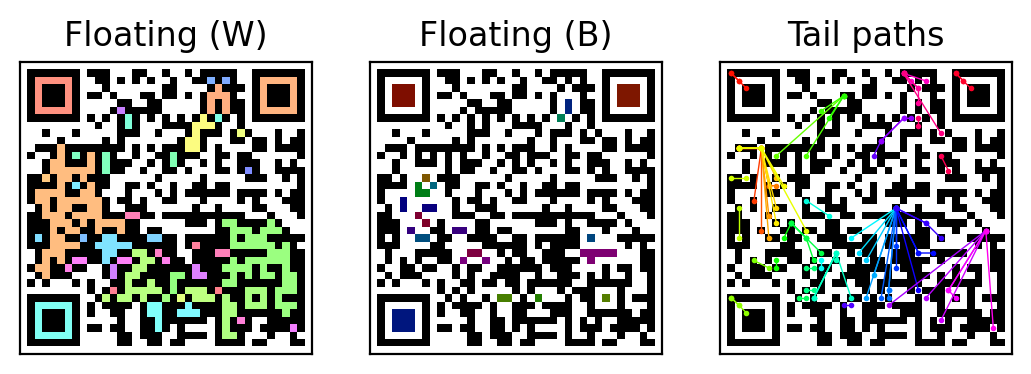

In [4]:
def compute_segment_neighbors_map(segmented_image):
    segment_neighbors = [[] for i in range(int(np.max(segmented_image)+1))]

    sample_offsets = ((1,0),(-1,0),(0,1),(0,-1))

    for px in range(1,W-1):
        for py in range(1,H-1):
            segment_id = segmented_image[py,px]

            for i,j in sample_offsets:
                neighbor_id = segmented_image[py+j,px+i]
                if neighbor_id != segment_id and neighbor_id not in segment_neighbors[segment_id]:
                    segment_neighbors[segment_id].append(neighbor_id)
                    segment_neighbors[neighbor_id].append(segment_id)
    
    return segment_neighbors

segment_neighbors = compute_segment_neighbors_map(segmented_image)


floating_segments = [[],[]]

for segment_id in range(n_segments):
    if segment_id != border_segment:
        match(segment_types[segment_id]):
            case 0:
                black_neighbor_check = sum([1-segment_types[i] for i in segment_neighbors[segment_id]])
                if black_neighbor_check == 0 and border_segment not in segment_neighbors[segment_id]:
                    floating_segments[0].append(segment_id)
            case 1:
                white_neighbor_check = sum([segment_types[i] for i in segment_neighbors[segment_id]])
                if white_neighbor_check == 0 and border_segment not in segment_neighbors[segment_id]:
                    floating_segments[1].append(segment_id)

all_floating_segments = floating_segments[0]+floating_segments[1]

def travel_to_end(visited,path_lengths,path):
    results = []
    if "sum([(neighbor in all_floating_segments) for neighbor in segment_neighbors[path[-1]]]) == len(segment_neighbors[path[-1]])" and path[-1] in all_floating_segments and (path[-1] not in path_lengths.keys() or path_lengths[path[-1]] > len(path)):
        path_lengths[path[-1]] = len(path)
        results.append(path)
    for neighbor in segment_neighbors[path[-1]]:
        # if path[-1] in all_floating_segments and neighbor not in all_floating_segments:
        #     continue
        if ((path[-1],neighbor) not in visited or (neighbor in path_lengths.keys() and path_lengths[neighbor] > len(path)+1)) and neighbor not in path:
            visited.append((path[-1],neighbor))
            result = travel_to_end(visited,path_lengths,path+[neighbor])
            if result:
                results+=result
    results = [result for result in results if path_lengths[result[-1]] == len(result)]
    if len(results) > 0:
        return results
    return None

visited = []
path_lengths = {}
tail_search_results = []
tail_search_result = None
last_visited_length = -1
while len(visited) != last_visited_length:
    last_visited_length = len(visited)
    tail_search_result = travel_to_end(visited,path_lengths,[border_segment])
    if tail_search_result:
        tail_search_results += tail_search_result

floating_segment_chains = [[chain_segment for chain_segment in chain if chain_segment in all_floating_segments] for chain in tail_search_results]
print(floating_segment_chains)

floating_segment_chains_lut = {}

for i,tail_chain in enumerate(tail_search_results):
    for segment_id in tail_chain:
        if segment_id in all_floating_segments:
            floating_segment_chains_lut[segment_id] = i

floating_segments_mask = np.zeros((W,H))
for segment_id in floating_segments[0]:
    floating_segments_mask-=(segmented_image == segment_id)
for segment_id in floating_segments[1]:
    floating_segments_mask+=(segmented_image == segment_id)

plt.rcParams['figure.dpi'] = 200
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

for ax in (ax1,ax2,ax3):
    ax.set_xticks([], [])
    ax.set_yticks([], [])

ax1.set_title("Floating (W)")
ax1.imshow(img_data, cmap="Greys_r")
ax1.imshow(segmented_image*np.maximum(0,floating_segments_mask), alpha=np.maximum(0,floating_segments_mask)*0.5, cmap="hsv",vmin=0,vmax=n_segments-1)

ax2.set_title("Floating (B)")
ax2.imshow(img_data, cmap="Greys_r")
ax2.imshow(segmented_image*np.maximum(0,-1*floating_segments_mask), alpha=np.maximum(0,-1*floating_segments_mask)*0.5, cmap="hsv",vmin=0,vmax=n_segments-1)

ax3.set_title("Tail paths")
ax3.imshow(img_data, cmap="Greys_r")

tail_path_lines_x = []
tail_path_lines_y = []
for result in tail_search_results:
    print(result)
    tail_path_lines_x.append([])
    tail_path_lines_y.append([])
    for segment_id in result:
        if segment_id == border_segment:
            continue
        tail_path_lines_x[-1].append(np.where(segmented_image == segment_id)[1][0])
        tail_path_lines_y[-1].append(np.where(segmented_image == segment_id)[0][0])

for i,(x,y) in enumerate(zip(tail_path_lines_x,tail_path_lines_y)):
    ax3.plot(x,y,'o-', markersize=1, linewidth=.5, color=mpl.colormaps['hsv'](i/len(tail_path_lines_x)))

plt.show()

Creating stencil: 3
[[4], [4, 3], [13], [13, 103], [13, 113], [13, 56], [13, 56, 81], [13, 144], [13, 87], [13, 18], [13, 105], [13, 146], [13, 82], [13, 114], [15], [84], [75], [75, 98], [133], [65], [64], [117], [70], [129], [90], [83], [83, 128], [83, 141], [38], [119], [150], [40], [40, 127], [40, 37], [143], [130], [86], [140], [132], [48], [45], [39], [39, 44], [32], [148], [122], [142], [142, 131], [152], [46], [46, 89], [76], [62], [26], [26, 69], [78], [42], [136], [43], [43, 34], [126], [93], [94], [10], [10, 96], [29], [73], [100], [11], [11, 5]]
Creating stencil: 4
[[], [3], [], [103], [113], [56], [56, 81], [144], [87], [18], [105], [146], [82], [114], [], [], [], [98], [], [], [], [], [], [], [], [], [128], [141], [], [], [], [], [127], [37], [], [], [], [], [], [], [], [], [44], [], [], [], [], [131], [], [], [89], [], [], [], [69], [], [], [], [], [34], [], [], [], [], [96], [], [], [], [], [5]]
Creating stencil: 5
[[], [], [], [], [], [], [81], [], [], [], [], [], [], 

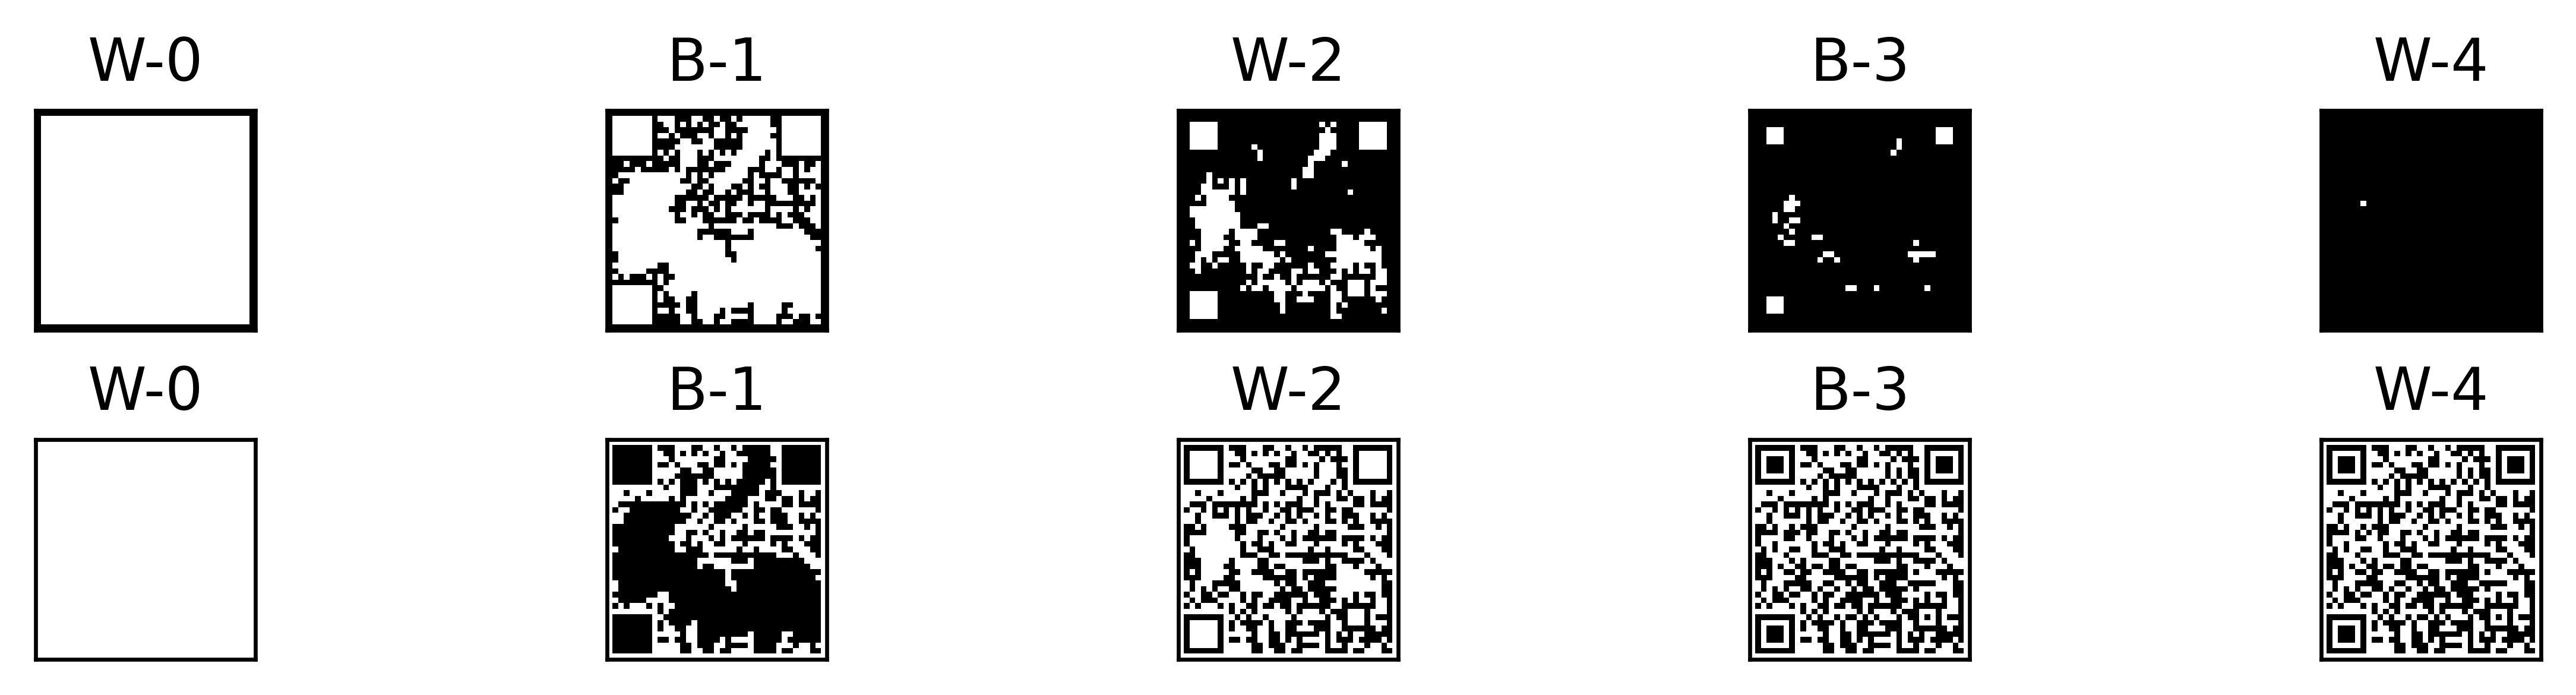

0


In [5]:
target_img = img_data/255

stencil0 = np.zeros_like(target_img)
stencil0[1:-1,1:-1] = 1

stencil1 = 1-target_img + np.maximum(0,floating_segments_mask)

stencils = [stencil0,stencil1]

n_floating_segments_left = len(all_floating_segments)
floating_segment_chains_left = [x.copy() for x in floating_segment_chains]

stencil_simulation_steps = [np.ones_like(stencil1),np.ones_like(stencil1),1-stencil1]

last_color = 0
while sum([len(x) for x in floating_segment_chains_left]) > 0:
    print(f'Creating stencil: {len(stencils)+1}')

    new_stencil = np.zeros_like(stencil1)
    new_stencil_segments = set()
    included_chains = []

    for i,chain in enumerate(floating_segment_chains_left):
        while (
            len(floating_segment_chains_left[i]) > 0
            and segment_types[floating_segment_chains_left[i][0]] == min(np.sum(stencil_simulation_steps[-1]*(segmented_image==floating_segment_chains_left[i][0])),1)
        ):
            floating_segment_chains_left[i].pop(0)

    print(floating_segment_chains_left)

    for i,chain in enumerate(floating_segment_chains_left):
        if len(chain) > 0:
            segments_drawn = 0

            for j,chain_segment in enumerate(chain):
                if ( 
                    segments_drawn == 0 
                    and segment_types[chain_segment] == min(np.sum(stencil_simulation_steps[-1]*(segmented_image==chain_segment)),1)
                ):
                    continue
                segments_drawn+=1
                new_stencil_segments.add(chain_segment)
                new_stencil+=segmented_image==chain_segment
    
    new_stencil = np.minimum(new_stencil,1)
    if np.sum(new_stencil) == 0:
        break

    stencils.append(new_stencil)
    last_color = 1-last_color
    new_simulation_step = stencil_simulation_steps[-1].copy()
    match(last_color):
        case 0:
            new_simulation_step *= 1-new_stencil
        case 1:
            new_simulation_step = np.minimum(new_simulation_step+new_stencil,1)
    stencil_simulation_steps.append(new_simulation_step)


plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.constrained_layout.use'] = False
fig,(axes_a,axes_b) = plt.subplots(2,len(stencils), figsize=(10,2))
fig.subplots_adjust(hspace=0.5)

for i,(ax_a,ax_b) in enumerate(zip(axes_a,axes_b)):
    ax_a.set_xticks([], [])
    ax_a.set_yticks([], [])
    ax_b.set_xticks([], [])
    ax_b.set_yticks([], [])

    color = 'B' if (i+1)%2 == 0 else 'W'

    ax_a.set_title(f"{color}-{i}")
    ax_a.imshow(stencils[i], cmap="Greys_r")
    # ax_a.imshow(stencils[i]*segmented_image,alpha=stencils[i]*0.5,cmap="hsv",vmin=0,vmax=n_segments-1)

    ax_b.set_title(f"{color}-{i}")
    ax_b.imshow(stencil_simulation_steps[i+1], cmap="Greys_r", vmax=1,vmin=0)
    # ax_b.imshow(stencils[i]*segmented_image,alpha=stencils[i]*0.5,cmap="hsv",vmin=0,vmax=n_segments-1)

plt.show()

print((target_img.shape[0]*target_img.shape[1])-np.sum(target_img==stencil_simulation_steps[-1]))

# plt.rcParams['figure.dpi'] = 600
# fig, axes = plt.subplots(1,len(stencil_simulation_steps)-1)

# for i,ax in enumerate(axes):
#     ax.set_xticks([], [])
#     ax.set_yticks([], [])

#     color = 'B' if (i+1)%2 == 0 else 'W'

#     if i > 0:
#         ax.imshow(stencils[i]*segmented_image,alpha=stencils[i]*0.5,cmap="hsv",vmin=0,vmax=n_segments-1)

# plt.show()

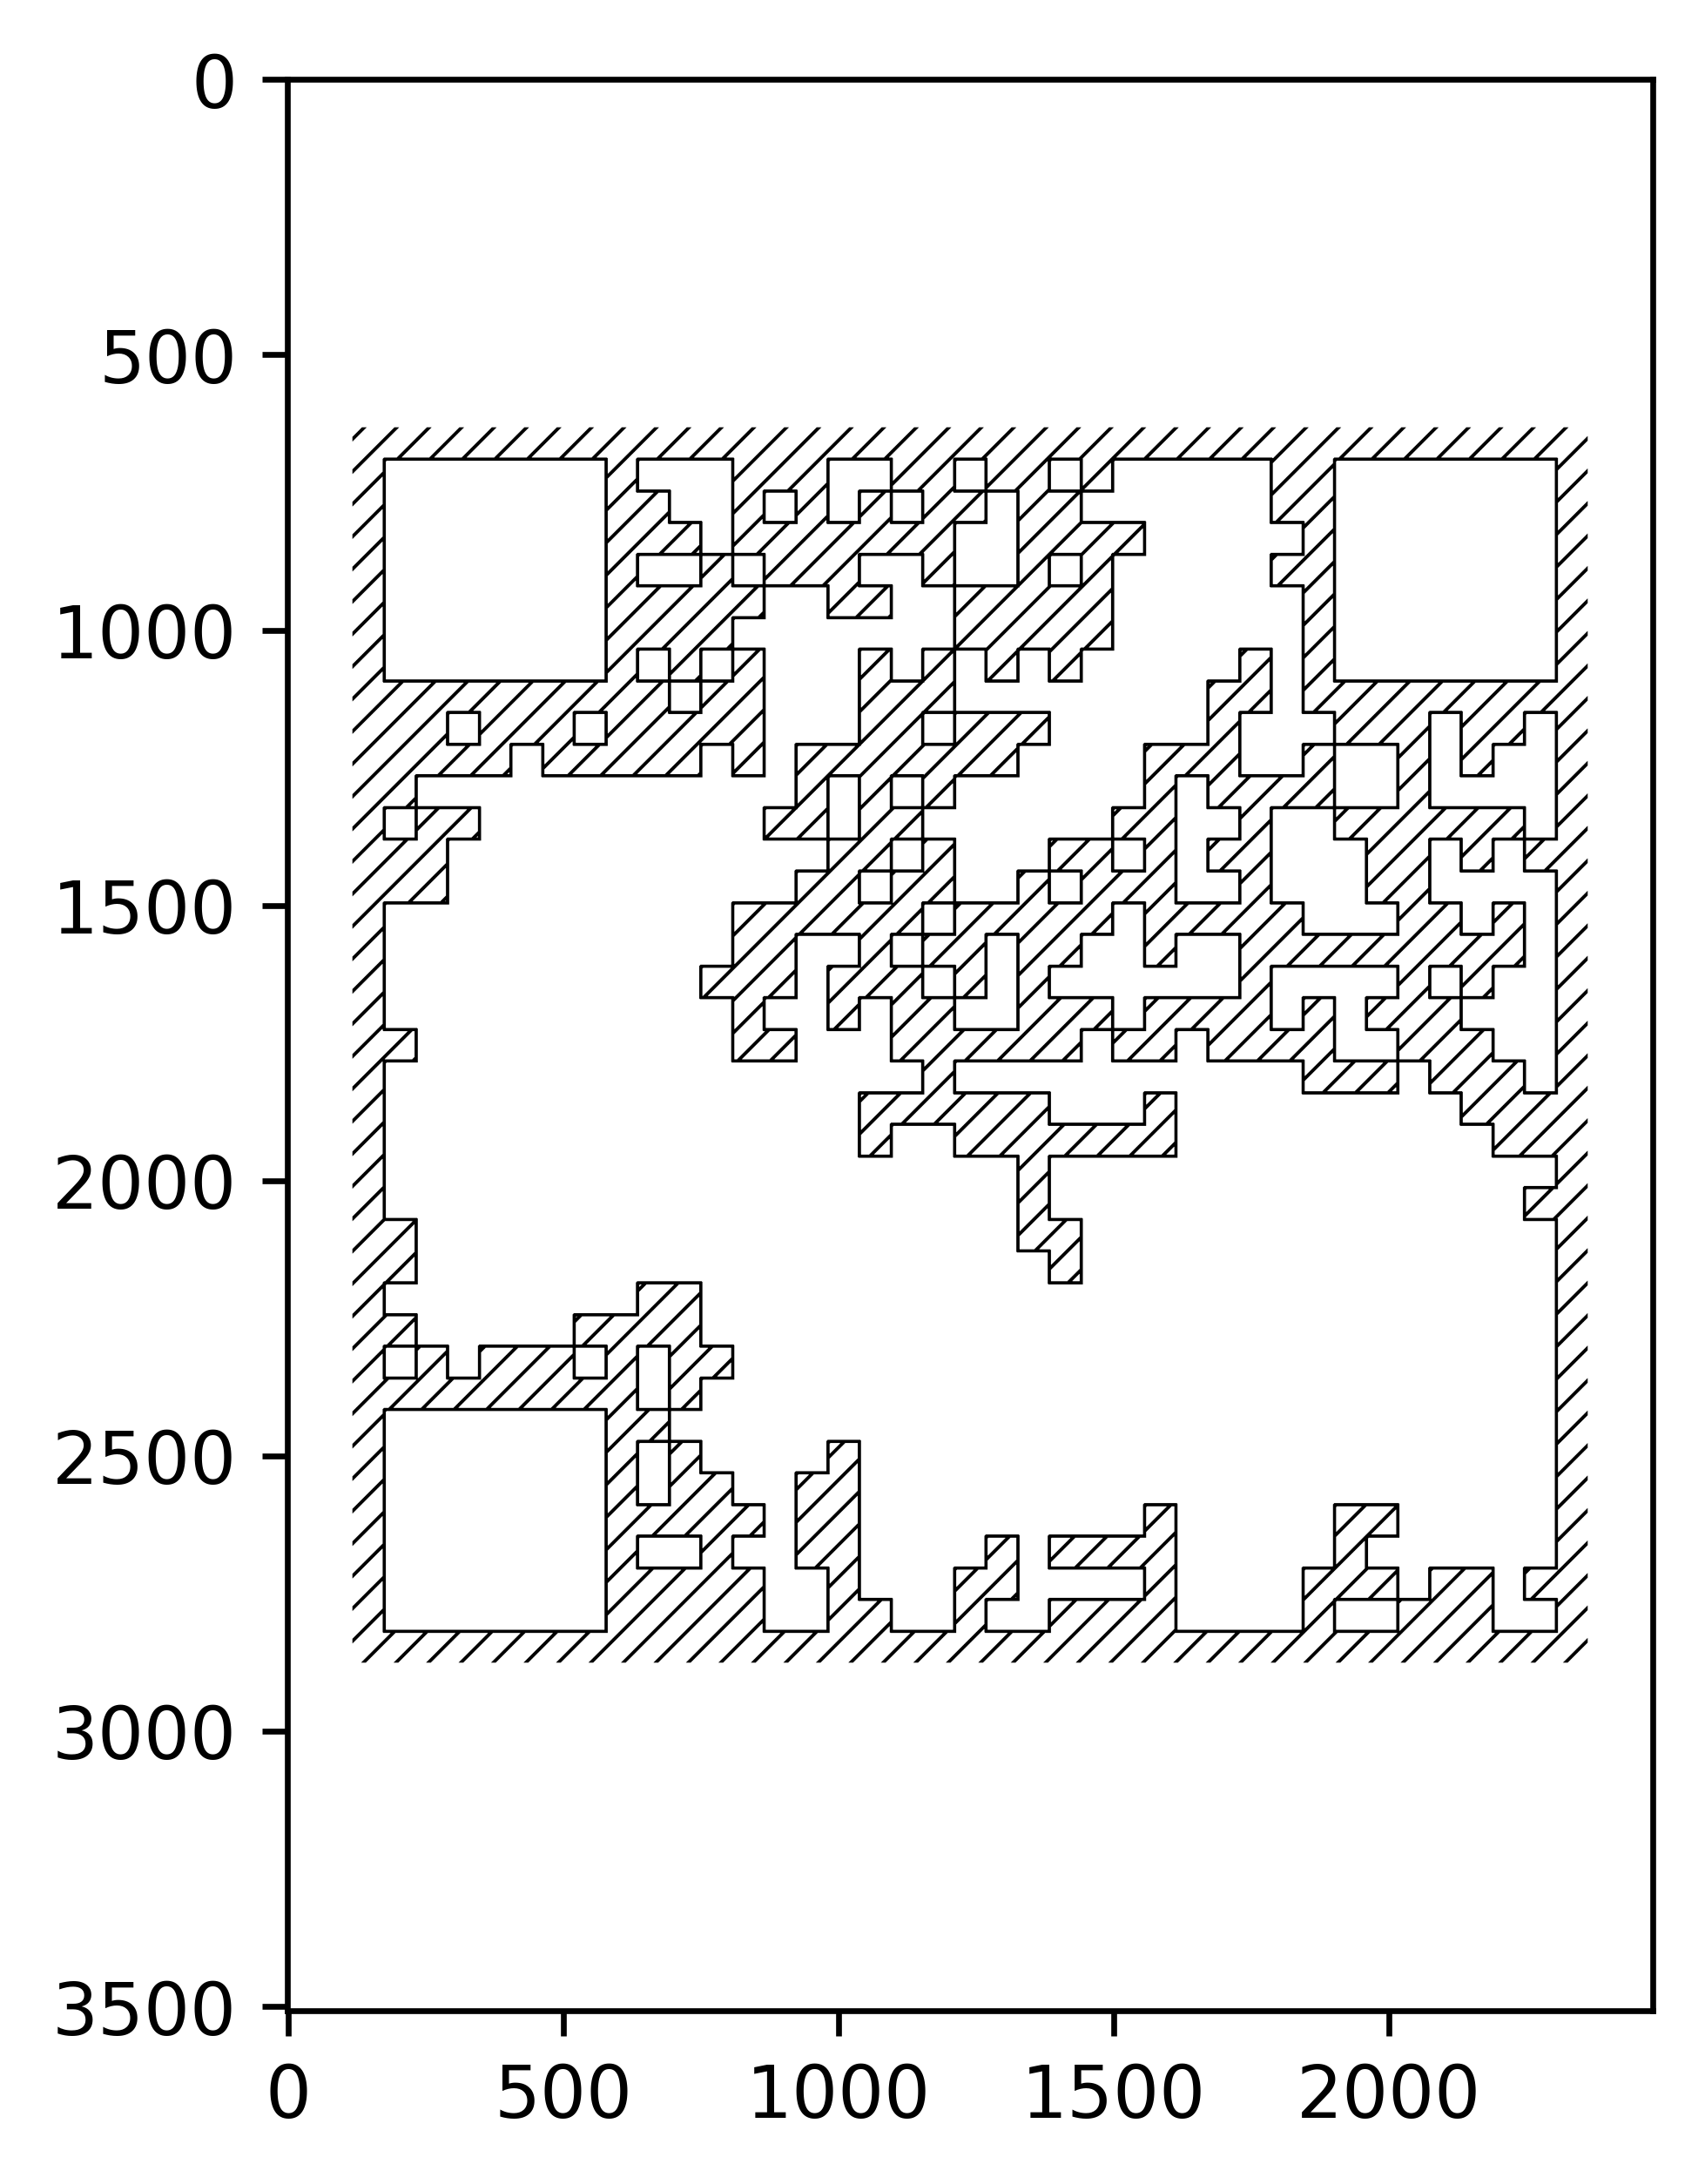

In [6]:
A4_SIZE_CM = (21.0, 29.7)
A4_SIZE_PX = (2480, 3508)

A4_MARGIN_CM = 1.0
A4_MARGIN_PX = round(A4_SIZE_PX[0]*(A4_MARGIN_CM/A4_SIZE_CM[0]))

A4_STROKE_WIDTH_CM = 0.1
A4_STROKE_WIDTH_PX = round(A4_SIZE_PX[0]*(A4_STROKE_WIDTH_CM/A4_SIZE_CM[0]))

A4_FILL_PATTERN_GAPS_CM = 0.5
A4_FILL_PATTERN_GAPS_PX = round(A4_SIZE_PX[0]*(A4_FILL_PATTERN_GAPS_CM/A4_SIZE_CM[0]))

A4_TARGET_QR_CODE_WIDTH_PX = A4_SIZE_PX[0]-2*A4_MARGIN_PX



def resize_qr_code(image: np.ndarray, target_width: int) -> np.ndarray:
    # Get the original dimensions of the image
    width = image.shape[1]
    
    # Calculate the scaling factor based on the target width
    scale_factor = target_width // width

    # Resize the image using nearest neighbor interpolation to avoid smoothing
    resized_image = cv2.resize(image, (target_width, target_width), interpolation=cv2.INTER_NEAREST)
    
    return resized_image

def generate_hr_stencil(raw_stencil):
    stencil_a4 = np.ones(A4_SIZE_PX[::-1])
    upscaled_stencil = resize_qr_code(raw_stencil,A4_TARGET_QR_CODE_WIDTH_PX)

    stroke_width = A4_STROKE_WIDTH_PX+(A4_STROKE_WIDTH_PX%2)
    kernel = np.ones((stroke_width//2,stroke_width//2), np.uint8) 
    stencil_edges = np.minimum(cv2.dilate(cv2.Canny(upscaled_stencil.astype(np.uint8),0.5,1),kernel),1)

    w,h = A4_SIZE_PX

    py = (A4_SIZE_PX[1]//2)-(A4_TARGET_QR_CODE_WIDTH_PX//2)
    center_rect = (slice(py,py+A4_TARGET_QR_CODE_WIDTH_PX),slice(A4_MARGIN_PX,-A4_MARGIN_PX))

    pixel_coords = np.mgrid[0:h, 0:w]
    stencil_a4[center_rect][(((pixel_coords[0]+pixel_coords[1])%A4_FILL_PATTERN_GAPS_PX)<np.sqrt(stroke_width**2/2))[center_rect] & (upscaled_stencil<1)] = 0

    stencil_a4[center_rect][stencil_edges>0] = 0
    
    return stencil_a4
    
    
plt.imshow(generate_hr_stencil(stencils[1]),cmap='Greys_r')
plt.show()
stencils_a4 = []